# Version information

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
#import plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)
import plotly.express as px
import seaborn as sns
import math
import plotly.graph_objects as go
from scipy.interpolate import griddata
from plotly.subplots import make_subplots



##Import Nodal_force from CSV_3rd FEA
Should be check the Name of Position data index by 'columns'
transfer 'XYZ' frame to 'cylindrical coordinate'


In [19]:
Nodal_Force=pd.read_csv('Z:/01_Codes_Projects/Pyleecan_fork/Nodal_force.csv')
Nodal_Force.columns
Nodal_Force['Position X']
temp=Nodal_Force['Position X'].pow(2)+Nodal_Force['Position Y'].pow(2)
Nodal_Force['Position R']=temp.pow(0.5)
Nodal_Force['ARCTAN']=np.arctan(Nodal_Force['Position Y']/Nodal_Force['Position X'])
Nodal_Force['Rad2deg']=np.degrees(Nodal_Force['ARCTAN'])

##Summation of VWP
SID : Radius of inner stator  [mm]

In [238]:
Rag=140

del_theta=0.5 #example
P_del_theta=5

Pole=12
perio=0
Anti_perio=1


if perio==1:
    Periodicity=1
else:
    if Anti_perio==1:
         Periodicity=2

Simul_angle=360/12/Periodicity
Angle_Division=Simul_angle/Simul_angle/4



d_theta=Simul_angle/Angle_Division/100


df=Nodal_Force


#for 문 수립
#Surface force density  단위 [N/m2]로 해야함
#Nodal Force 단위 [N]임

#첫번째 0-15deg stress P_d
mask = (df['Rad2deg'] > 0) & (df['Rad2deg'] <= d_theta) #row
filtered_df=df.loc[mask]
sum_filtered_df=df.loc[mask].sum(axis=0)
sum_filtered_df=sum_filtered_df.astype('float')

sum_stress=sum_filtered_df/d_theta/Rag

sum_stress_list=[sum_stress]

mask


0       False
1       False
2       False
3       False
4       False
        ...  
7294    False
7295    False
7296    False
7297    False
7298    False
Name: Rad2deg, Length: 7299, dtype: bool

In [ ]:
for i in range(0,3000)

In [231]:

for i in range(0,3000):
    if df.iloc[i]['Rad2deg']== True:
         print i,df.iloc[i]['BoolCol']
Nodal_Force.loc[2]
Nodal_Force.iloc[[2]].sum()

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(i,df.iloc[i]['BoolCol'])? (Temp/ipykernel_68672/218782166.py, line 3)

# Analytical Air-Gap Surface Force Transfer
One of the main method to compute magnetic forces in electrical machine for vibroacoustic study is the Air-gap Surface Force (AGSF) method based on the Maxwell Stress Tensor (MST). The idea is to compute an equivalent magnetic pressure in the air-gap. However, there are two contradictory issue to take into account: 
- The magneto-static finite element solution contains minimal numerical error in the middle of the air-gap. 
- However, the theoretical application of the MST should be more accurate on the stator bore radius. 

To solve this issue, it is proposed to compute the AGSF at stator bore radius from the AGSF compute in the middle of the air-gap. It is based on the following scientific article: [PILE, Raphaël, LE BESNERAIS, Jean, PARENT, Guillaume, et al. Analytical study of air-gap surface force–application to electrical machines. Open Physics, 2020, vol. 18, no 1, p. 658-673.](https://www.degruyter.com/view/journals/phys/18/1/article-p658.xml)

This tutorial explains how to use the feature of Air-Gap Surface Force (AGSF) transfer in Pyleecan, and presents some numerical application for an SPMSM electrical machine. 

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_AGSF_transfer.ipynb).

## Import Pyleecan modules and machine definition

In [2]:
import pytest
from os.path import join
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from Tests import save_validation_path as save_path

<IPython.core.display.Javascript object>


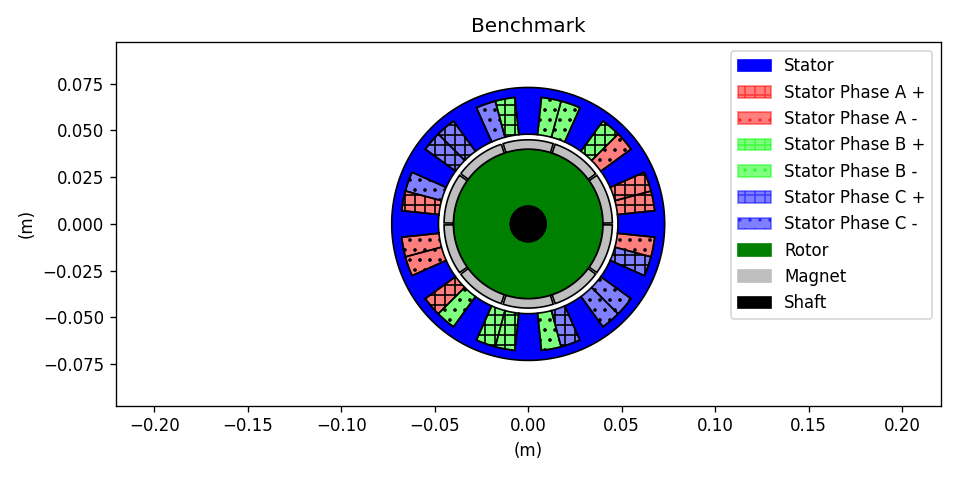

In [3]:
%matplotlib notebook
# Load machine
Benchmark = load(join(DATA_DIR, "Machine", "Benchmark.json"))
Benchmark.plot()

## Simulation definition
The electromagnetic field is solved in a 2D magnetostatic simulation using FEMM software. The time dependancy is not considered in the following demonstration to lighten calculations. 

In [4]:
# Prepare simulation
simu = Simu1(name="AC_IPMSM_plot", machine=Benchmark)

simu.input = InputCurrent(
    Id_ref=0, Iq_ref=0, Ir=None, Na_tot=5 * 2 ** 8, Nt_tot=2, N0=1200
)

# Configure simulation
simu.elec = None

simu.force = ForceMT()

simu.mag = MagFEMM(
    is_periodicity_a=False,
    is_periodicity_t=False,
    is_sliding_band=False,
    Kmesh_fineness=4,
    type_BH_rotor=1,
    type_BH_stator=1,    
)

simu2 = simu.copy()
simu2.force.is_agsf_transfer=True
simu2.force.max_wavenumber_transfer = 70













TypeError: __init__() got an unexpected keyword argument 'Id_ref'

## Validation of the AGSF transfer law at 90% of the air-gap
The air-gap is the area between the rotor bore radius (Rrbo) and the stator bore radius (Rsbo). The classic application of Maxwell stress tensor to compute AGSF is performed in the middle of the airgap (K=50%).

The next cell can be modified to perform several simulation with different radius of calculation for AGSF.

In [11]:
# Tests at 90% of the air-gap (this list can be modified to add other cases)
K = [90]

Now, the loop on simulation can be performed. For each values in K, the AGSF is either:
- Directly extracted at the desired radius 
- or calculated from the knowledge of AGSF at K=50% using the transfer law.

In [13]:
Rsbo = 0.0480
Rrbo = 0.0450

Nk = len(K)

simu_list = list()
simu_list2 = list()

out_list = list()
out_list2 = list()

AGSF_list = list()
AGSF_list2 = list()

legend_list = list()
legend_list2 = list()

for ik in range(Nk):
    k = K[ik]
    Rag = (Rsbo - Rrbo) * k / 100 + Rrbo
    
    # Simu with is_agsf_transfer=False
    simu_list.append(simu.copy())
    simu_list[ik].mag.Rag_enforced = Rag
    out_list.append(simu_list[ik].run())
    legend_list.append(str(k) + "%")
    AGSF_list.append(out_list[ik].force.AGSF)
    
    # Simu2 with is_agsf_transfer=True
    simu_list2.append(simu2.copy())
    simu_list2[ik].force.Rsbo_enforced_transfer = Rag
    out_list2.append(simu_list2[ik].run())
    legend_list2.append(str(k) + "%")
    AGSF_list2.append(out_list2[ik].force.AGSF)

[13:46:17] Starting running simulation AC_IPMSM_plot (machine=Benchmark)


InputError: OPdq object can't have felec and N0 both None

The results can be plotted to check the validity of the AGSF transfer law. For example, at 90% of the air-gap, there is a very good match between the transfer application and the direct method:

In [14]:
from pyleecan.Functions.Plot import dict_2D
ik = 0
out_list[ik].force.AGSF.plot_2D_Data(
    "wavenumber=[0,22]",
    "freqs=0", #equivalent to time=0 in this case
    data_list=[AGSF_list2[ik]],
    legend_list=["Direct", "Transfer"],
    is_show_fig=True,
    **dict_2D
)

IndexError: list index out of range

## Demonstration of the accuracy improvement at 99% of the air-gap
The AGSF transfer results are compared to 2 different simulations in order to show the benefits in term of accuracy:
- A simulation with a coarse mesh, which is also used as input for the AGSF transfer
- and a simulation with a fine mesh which is the reference.

For all simulations, the compared output is the AGSF at 99% of the air-gap radius. 


In [15]:
Rs = (Rsbo - Rrbo) * 99 / 100 + Rrbo

simu2 = simu.copy()
simu2.force.is_agsf_transfer = True
simu2.force.Rsbo_enforced_transfer = Rs
simu2.force.max_wavenumber_transfer = 100

out2 = simu2.run()

# Enforced Rag for ref
simu.mag.Rag_enforced = Rs
out = simu.run()

# Simu with low finesness
simu3 = simu.copy()
simu3.mag.Kmesh_fineness = 1
out3 = simu3.run()

[13:47:52] Starting running simulation AC_IPMSM_plot (machine=Benchmark)


InputError: OPdq object can't have felec and N0 both None

The comparison is performed in the plot below. This significative results are observed in the tangential direction. The improvement can be observed since the AGSF computed with transfer law from the coarse mesh is more accurate on most wavenumbers with respect to the fine mesh. 

In [ ]:
AGSF_list = list()
AGSF_list.append(out2.force.AGSF)
AGSF_list.append(out3.force.AGSF)
legend_list = ["Fine Mesh", "Transfert based on Coarse Mesh", "Coarse Mesh"]

out.force.AGSF.plot_2D_Data(
    "wavenumber=[0,22]",
    "freqs=0", #equivalent to time=0 in this case
    data_list=AGSF_list,
    legend_list=legend_list,
    is_show_fig=True,
    **dict_2D
)

The discrepancies become more and more significative when high wavenumbers are considered. 

In [ ]:
out.force.AGSF.plot_2D_Data(
    "wavenumber=[0,100]",
    "freqs=0", #equivalent to time=0 in this case
    data_list=AGSF_list,
    legend_list=legend_list,
    is_show_fig=True,
    is_auto_ticks = False,
    **dict_2D
)